In [1]:
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyIEEM.models.utils import initialize_model

In [5]:
country = 'SWE'
spatial = True
age_classes = pd.IntervalIndex.from_tuples([(0,5),(5,10),(10,15),(15,20),(20,25),(25,30),(30,35),(35,40),(40,45),(45,50),(50,55),(55,60),(60,65),(65,70),(70,75),(75,80),(80,120)], closed='left')

In [5]:
def compute_beta(R0, delta, gamma, s, N, demography):
    beta_i = R0/(s*(delta+gamma)*np.expand_dims(np.sum(N, axis=0),axis=1))
    return sum(np.squeeze(beta_i)*demography/sum(demography))

In [9]:
N = np.squeeze(model.parameters['N']['other'] + model.parameters['G']*model.parameters['N']['work'])
demography = pd.read_csv(f'../data/interim/epi/demographic/age_structure_{country}_2019.csv', index_col=[0, 1]).groupby(by='age').sum().squeeze()
demography = demography.groupby(pd.cut(demography.index.values, age_classes)).sum()
compute_beta(3.3, model.parameters['delta'], model.parameters['gamma'], model.parameters['s'], N, demography.values)

ValueError: operands could not be broadcast together with shapes (11,11) (17,17,11) 

In [30]:
simulation_start = '2019-12-15'
model = initialize_model(country, age_classes, spatial, simulation_start, contact_type='absolute_contacts')

2019-12-15 00:00:00 0.0 0.0010642826734780756
2019-12-15 00:27:47.449834 0.0 0.0010642826734780756
2019-12-15 00:20:45.848326 0.0 0.0010642826734780756
2019-12-15 00:31:08.772489 0.0 0.0010642826734780756
2019-12-15 00:41:31.696652 1.1503458715736787e-15 0.0010642826734780756
2019-12-15 04:09:10.179912 1.8175148810508546e-14 0.0010642826734780756
2019-12-15 05:52:59.421542 2.789593179229479e-13 0.0010642826734780756
2019-12-15 07:36:48.663172 1.4620507604580284e-12 0.0010642826734780756
2019-12-15 13:15:10.464117 3.800932767956972e-12 0.0010642826734780756
2019-12-15 16:04:21.364589 8.513704398480617e-12 0.0010642826734780756
2019-12-15 18:53:32.265062 1.3706031027385782e-11 0.0010642826734780756
2019-12-16 03:20:46.094828 2.380279230656777e-11 0.0010642826734780756
2019-12-16 07:34:23.009711 3.9924628792653776e-11 0.0010642826734780756
2019-12-16 11:47:59.924594 5.682684469046797e-11 0.0010642826734780756
2019-12-17 00:54:44.288872 8.748835507470092e-11 0.0010642826734780756
2019-12-1

2020-01-25 20:18:32.960412 7.939474032727872e-08 0.0010642826734780756
2020-01-26 07:19:29.190899 8.5844169376219e-08 0.0010642826734780756
2020-01-27 06:18:13.112920 9.353327348740431e-08 0.0010642826734780756
2020-01-27 17:47:35.073931 1.017789227910414e-07 0.0010642826734780756
2020-01-28 05:16:57.034942 1.1040077923168547e-07 0.0010642826734780756
2020-01-29 04:29:31.389465 1.2069296354233302e-07 0.0010642826734780756
2020-01-29 16:05:48.566727 1.3174200083627342e-07 0.0010642826734780756
2020-01-30 03:42:05.743989 1.4329609811287693e-07 0.0010642826734780756
2020-01-31 02:17:08.927390 1.5698847406089447e-07 0.0010642826734780756
2020-01-31 13:34:40.519090 1.7161006542575056e-07 0.0010642826734780756
2020-02-01 00:52:12.110791 1.868511032760998e-07 0.0010642826734780756
2020-02-01 23:11:44.007525 2.0486136710732752e-07 0.0010642826734780756
2020-02-02 10:21:29.955891 2.2406354035007926e-07 0.0010642826734780756
2020-02-02 21:31:15.904258 2.440446409006149e-07 0.0010642826734780756


2020-03-18 20:26:33.181165 0.00014005119664406716 0.0010642826734780756
2020-03-19 20:27:12.539733 0.00014907908335161783 0.0010642826734780756
2020-03-20 08:27:32.219016 0.00015845674110813421 0.0010642826734780756
2020-03-20 20:27:51.898300 0.00016827031733333277 0.0010642826734780756
2020-03-21 18:42:23.996425 0.0001795552899129216 0.0010642826734780756
2020-03-22 05:49:40.045488 0.0001910406649441956 0.0010642826734780756
2020-03-22 16:56:56.094551 0.0002028845273355433 0.0010642826734780756
2020-03-21 15:26:37.351758 0.00020290593803994487 0.0010642826734780756
2020-03-22 00:56:00.078488 0.0002129293462065417 0.0010642826734780756
2020-03-22 10:25:22.805217 0.00022318750843181742 0.0010642826734780756
2020-03-23 04:21:59.637263 0.00023449254876876233 0.0010642826734780756
2020-03-23 13:20:18.053286 0.00024589447946414544 0.0010642826734780756
2020-03-23 22:18:36.469309 0.00025736916522422826 0.0010642826734780756
2020-03-24 17:38:42.614212 0.0002700339472669532 0.00106428267347807

2020-05-03 10:37:21.121477 0.0011244531394954303 0.0010642826734780756
2020-05-03 20:24:23.633571 0.0011232764761113423 0.0010642826734780756
2020-05-04 17:07:36.269318 0.001121381424794641 0.0010642826734780756
2020-05-05 03:29:12.587191 0.0011194722316375469 0.0010642826734780756
2020-05-05 13:50:48.905064 0.001117369785816058 0.0010642826734780756
2020-05-06 11:54:34.899551 0.0011144692533787293 0.0010642826734780756
2020-05-06 22:56:27.896794 0.001111564890422688 0.0010642826734780756
2020-05-07 09:58:20.894037 0.0011084705931727558 0.0010642826734780756
2020-05-08 07:02:34.635416 0.0011046278319884943 0.0010642826734780756
2020-05-08 17:34:41.506105 0.0011008193791046867 0.0010642826734780756
2020-05-09 04:06:48.376795 0.00109686524478519 0.0010642826734780756
2020-05-10 00:07:01.265114 0.0010922137910868374 0.0010642826734780756
2020-05-10 10:07:07.709273 0.0010876346193191826 0.0010642826734780756
2020-05-10 20:07:14.153433 0.0010829598996623783 0.0010642826734780756
2020-05-11 

2020-07-02 04:03:59.823053 0.0003882491011840844 0.0010642826734780756
2020-07-02 09:19:57.973879 0.00038596304656958414 0.0010642826734780756
2020-07-02 14:35:56.124705 0.0003837781269537021 0.0010642826734780756
2020-07-03 15:54:17.655650 0.0003815536637736755 0.0010642826734780756
2020-07-04 04:33:28.421123 0.00037937378700964074 0.0010642826734780756
2020-07-04 17:12:39.186596 0.00037723810417707203 0.0010642826734780756
2020-07-05 16:38:05.807097 0.0003751022209335319 0.0010642826734780756
2020-07-06 04:20:49.117347 0.0003730341614015274 0.0010642826734780756
2020-07-06 16:03:32.427598 0.00037103414062151927 0.0010642826734780756
2020-07-05 13:10:31.877538 0.00037097056235430086 0.0010642826734780756
2020-07-05 23:09:28.223009 0.0003690575473640173 0.0010642826734780756
2020-07-06 09:08:24.568480 0.0003672156222325625 0.0010642826734780756
2020-07-07 05:06:17.259423 0.00036541951565800405 0.0010642826734780756
2020-07-07 15:05:13.604894 0.0003636976367561268 0.0010642826734780756


2020-09-02 12:43:57.953375 0.0009509147815782371 0.0010642826734780756
2020-09-02 18:26:01.997285 0.0009603169196162639 0.0010642826734780756
2020-09-03 18:06:12.628952 0.0009712396604593669 0.0010642826734780756
2020-09-04 05:56:17.944785 0.0009820611654218312 0.0010642826734780756
2020-09-04 17:46:23.260618 0.000993051425216584 0.0010642826734780756
2020-09-05 20:14:02.243590 0.0010057236414846985 0.0010642826734780756
2020-09-06 09:27:51.735076 0.0010182835887301992 0.0010642826734780756
2020-09-06 22:41:41.226561 0.0010310530150161312 0.0010642826734780756
2020-09-05 15:51:33.531053 0.0010303605055191653 0.0010642826734780756
2020-09-06 02:54:08.666271 0.0010415660094656855 0.0010642826734780756
2020-09-06 13:56:43.801489 0.0010528526567205325 0.0010642826734780756
2020-09-07 12:01:54.071924 0.0010653718057516625 0.0010642826734780756
2020-09-07 23:04:29.207141 0.001077624868705748 0.0010642826734780756
2020-09-08 10:07:04.342359 0.0010899111301583215 0.0010642826734780756
2020-09-

2020-11-01 14:22:55.539446 0.002156203015830737 0.0010642826734780756
2020-11-02 06:23:24.533003 0.0021558397226858618 0.0010642826734780756
2020-11-02 14:23:39.029782 0.0021554635807434315 0.0010642826734780756
2020-11-02 22:23:53.526561 0.002155136215670769 0.0010642826734780756
2020-11-02 02:33:31.275164 0.0021560280956434883 0.0010642826734780756
2020-11-02 08:38:49.143023 0.002155838360438069 0.0010642826734780756
2020-11-02 14:44:07.010882 0.002155683646964606 0.0010642826734780756
2020-11-03 02:24:06.162945 0.002155087302195115 0.0010642826734780756
2020-11-03 08:14:05.738977 0.002154662351512996 0.0010642826734780756
2020-11-03 14:04:05.315009 0.0021541664012307135 0.0010642826734780756
2020-11-04 13:15:07.542924 0.0021525860280485996 0.0010642826734780756
2020-11-05 00:50:38.656882 0.0021513254011844953 0.0010642826734780756
2020-11-05 12:26:09.770840 0.002149904090431278 0.0010642826734780756
2020-11-06 16:04:20.922256 0.0021473001063423954 0.0010642826734780756
2020-11-07 05

2019-12-30 21:11:50.781388 4.394742166402952e-09 0.0010642826734780756
2019-12-31 14:05:25.885644 4.667967121467429e-09 0.0010642826734780756
2020-01-01 06:59:00.989900 4.961837704377854e-09 0.0010642826734780756
2019-12-30 09:38:40.862479 4.961836903384168e-09 0.0010642826734780756
2019-12-30 20:45:41.007281 5.174143748694231e-09 0.0010642826734780756
2019-12-31 07:52:41.152084 5.3931749091241796e-09 0.0010642826734780756
2020-01-01 06:06:41.441688 5.647554827474129e-09 0.0010642826734780756
2020-01-01 17:13:41.586490 5.913357610067722e-09 0.0010642826734780756
2020-01-02 04:20:41.731292 6.1868663964160066e-09 0.0010642826734780756
2020-01-03 06:15:23.998607 6.515557570225482e-09 0.0010642826734780756
2020-01-03 19:12:45.132264 6.867445546350467e-09 0.0010642826734780756
2020-01-04 08:10:06.265921 7.235469436584355e-09 0.0010642826734780756
2020-01-05 07:30:01.550700 7.665078893431211e-09 0.0010642826734780756
2020-01-05 19:09:59.193089 8.117675909740376e-09 0.0010642826734780756
2020

2020-02-27 04:21:34.627898 1.1267074675277921e-05 0.0010642826734780756
2020-02-28 08:27:08.764217 1.1849729024724645e-05 0.0010642826734780756
2020-02-28 22:29:55.832377 1.2517345839777562e-05 0.0010642826734780756
2020-02-29 12:32:42.900536 1.3249202787423006e-05 0.0010642826734780756
2020-03-01 21:06:24.891238 1.4238612047879266e-05 0.0010642826734780756
2020-03-02 13:23:15.886588 1.5379785347709973e-05 0.0010642826734780756
2020-03-03 05:40:06.881939 1.663619882231165e-05 0.0010642826734780756
2020-02-29 23:39:07.054040 1.6618405530113544e-05 0.0010642826734780756
2020-03-01 05:12:19.130791 1.7351450941962025e-05 0.0010642826734780756
2020-03-01 10:45:31.207543 1.8081980642999853e-05 0.0010642826734780756
2020-03-01 21:51:55.361046 1.8870787348908836e-05 0.0010642826734780756
2020-03-02 03:25:07.437798 1.96629905782893e-05 0.0010642826734780756
2020-03-02 08:58:19.514549 2.0455618964270727e-05 0.0010642826734780756
2020-03-01 18:27:09.877980 2.0449632659168286e-05 0.001064282673478

2020-04-13 02:21:00.323619 0.001035283197425099 0.0010642826734780756
2020-04-13 19:35:28.687131 0.0010542903177392644 0.0010642826734780756
2020-04-14 12:49:57.050642 0.0010740382430045677 0.0010642826734780756
2020-04-15 22:19:36.905228 0.0010959275834430376 0.0010642826734780756
2020-04-16 15:04:26.832521 0.0011184545452377428 0.0010642826734780756
2020-04-17 07:49:16.759814 0.0011413376631830257 0.0010642826734780756
2020-04-15 13:16:59.704820 0.0011428592556841227 0.0010642826734780756
2020-04-16 01:30:31.031908 0.0011628215796017425 0.0010642826734780756
2020-04-16 13:44:02.358997 0.0011826739646136762 0.0010642826734780756
2020-04-17 14:11:05.013175 0.0012034017517606494 0.0010642826734780756
2020-04-18 02:24:36.340263 0.001224144384509974 0.0010642826734780756
2020-04-18 14:38:07.667352 0.001244628340695904 0.0010642826734780756
2020-04-19 15:19:25.108514 0.0012657474005869855 0.0010642826734780756
2020-04-20 03:40:03.829095 0.0012867869995371647 0.0010642826734780756
2020-04-2

2020-06-05 06:07:07.189909 0.0015249716377945068 0.0010642826734780756
2020-06-05 16:18:45.063600 0.0015165008547690026 0.0010642826734780756
2020-06-06 13:20:02.194115 0.0015073777603177767 0.0010642826734780756
2020-06-06 23:50:40.759373 0.0014986740325234906 0.0010642826734780756
2020-06-07 10:21:19.324630 0.001490114304135623 0.0010642826734780756
2020-06-08 07:21:09.639816 0.0014809390269253874 0.0010642826734780756
2020-06-08 17:51:04.797409 0.0014721884115470555 0.0010642826734780756
2020-06-09 04:20:59.955002 0.0014635912960053684 0.0010642826734780756
2020-06-10 00:57:17.783562 0.0014544336715034884 0.0010642826734780756
2020-06-10 11:15:26.697842 0.001445703283678692 0.0010642826734780756
2020-06-10 21:33:35.612122 0.0014371433031429347 0.0010642826734780756
2020-06-11 17:53:27.025047 0.001428059906118907 0.0010642826734780756
2020-06-12 04:03:22.731510 0.0014194023880410266 0.0010642826734780756
2020-06-12 14:13:18.437972 0.001410921755665527 0.0010642826734780756
2020-06-13

2020-08-04 21:19:15.024877 0.0008428117361039819 0.0010642826734780756
2020-08-05 07:38:56.570069 0.0008400679806039884 0.0010642826734780756
2020-08-05 17:58:38.115260 0.000837407135879522 0.0010642826734780756
2020-08-06 14:37:07.792710 0.0008346683916591153 0.0010642826734780756
2020-08-07 00:56:22.631435 0.0008320370466167542 0.0010642826734780756
2020-08-07 11:15:37.470161 0.0008294840908018972 0.0010642826734780756
2020-08-08 08:26:36.930814 0.0008268400812480545 0.0010642826734780756
2020-08-08 19:02:06.661140 0.0008242960476712128 0.0010642826734780756
2020-08-09 05:37:36.391467 0.0008218201698915734 0.0010642826734780756
2020-08-10 03:03:25.401497 0.0008192477999514445 0.0010642826734780756
2020-08-10 13:46:19.906512 0.0008167686423440685 0.0010642826734780756
2020-08-11 00:29:14.411527 0.0008143541326708864 0.0010642826734780756
2020-08-11 21:35:01.788392 0.0008118439730353309 0.0010642826734780756
2020-08-12 08:07:55.476824 0.0008094260746402076 0.0010642826734780756
2020-08

2020-10-04 19:22:31.457120 0.0005831853668890773 0.0010642826734780756
2020-10-05 16:14:18.937562 0.0005805328508241969 0.0010642826734780756
2020-10-06 02:40:12.677783 0.0005779620614879485 0.0010642826734780756
2020-10-06 13:06:06.418005 0.00057545591279203 0.0010642826734780756
2020-10-07 09:45:49.521025 0.0005728663804408196 0.0010642826734780756
2020-10-07 20:05:41.072535 0.0005703601058925679 0.0010642826734780756
2020-10-08 06:25:32.624045 0.0005679178427559595 0.0010642826734780756
2020-10-09 03:32:46.350904 0.0005653910085651299 0.0010642826734780756
2020-10-09 14:06:23.214333 0.000562943029679839 0.0010642826734780756
2020-10-10 00:40:00.077762 0.0005605580126334289 0.0010642826734780756
2020-10-10 22:09:22.370817 0.0005580884831719833 0.0010642826734780756
2020-10-11 08:54:03.517344 0.0005556971751834955 0.0010642826734780756
2020-10-11 19:38:44.663872 0.0005533647301769021 0.0010642826734780756
2020-10-12 16:55:22.680930 0.0005509577862781174 0.0010642826734780756
2020-10-1

2020-11-30 21:51:13.940566 0.0004432787250195079 0.0010642826734780756
2020-12-01 00:00:00 0.00044289206373062415 0.0010642826734780756


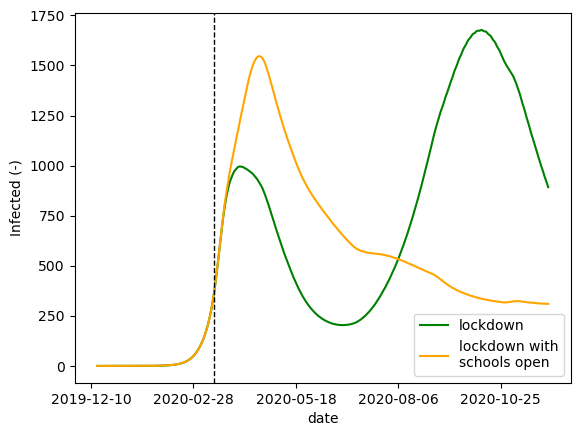

In [31]:
fig,ax = plt.subplots()

model.parameters['beta'] = 0.028
model.parameters['amplitude'] = 0.20

# economic lockdown, schools closed, preventive measures, social restrictions
model.parameters['economic_closures'].loc[slice(None)] = 1
out = model.sim([simulation_start, '2020-12-01'])
ax.plot(out.date, out.Hin.sum(dim=['age_class', 'spatial_unit']), color='green', label='lockdown')
#ax.plot(out.date, out.R.sum(dim=['age_class', 'spatial_unit']), color='green', label='lockdown')

# economic lockdown, schools open, preventive measures, social restrictions
model.parameters['economic_closures'].loc['P85'] = 0
out = model.sim([simulation_start, '2020-12-01'])
ax.plot(out.date, out.Hin.sum(dim=['age_class', 'spatial_unit']), 'orange', label='lockdown with\nschools open')

# do-nothing
#model.parameters['social_restrictions'] = 0
#model.parameters['economic_closures'].loc[slice(None)] = 0
#out = model.sim([simulation_start, '2020-12-01'])
#ax.plot(out.date, out.Hin.sum(dim=['age_class', 'spatial_unit']), color='red', label='do nothing')

ax.legend()

ax.axvline(x=datetime(2020, 3, 15), color='black', linestyle='--', linewidth=1)
ax.set_xlabel('date')
ax.set_ylabel('Infected (-)')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
plt.show()
plt.close()